### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
import seaborn as sns

import os
import pickle
import xgboost as xgb

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Looking into the dataset

In [3]:
# checking structure of data
print(f'df.shape: {df.shape}')
print(f'df.columns:\n{df.columns}\n')
df.head()

df.shape: (5110, 12)
df.columns:
Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# checking for any null values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# seeing overall stats of the dataset
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# getting info of columns
df.info()
print(f"Shape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
Shape: (5110, 12)


### Adjusting imbalance in data

Count of unique values:
0    4861
1     249
Name: stroke, dtype: int64


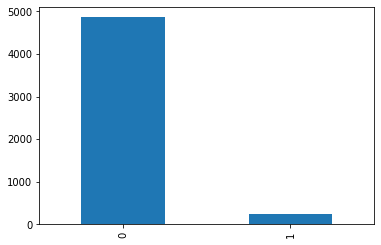

In [7]:
# checking balance of data
print(f"Count of unique values:\n{df['stroke'].value_counts()}")
df['stroke'].value_counts().plot(kind='bar')

Count of unique values:
0    351
1    249
Name: stroke, dtype: int64


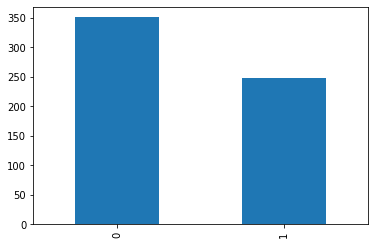

In [8]:
# the dataset is highly imbalanced, undersampling the abundant class

# shuffling and deleting few rows with stroke value = 0
df = df.sample(frac=1)
df.drop(df[df['stroke'] == 0].tail(4510).index, inplace=True)

# checking balance again
print(f"Count of unique values:\n{df['stroke'].value_counts()}")
df['stroke'].value_counts().plot(kind='bar')

### Cleaning (re-factoring) and visualising data

In [9]:
# replacing categorical data with corresponding integer value
cleanup_dict = {
    'gender':           {'Male':0, 'Female':1},
    'ever_married':     {'No':0, 'Yes':1},
    'Residence_type':   {'Urban':0, 'Rural':1},
    'work_type':        {'Never_worked':0, 'children':1,  'Govt_job':2, 'Private':3, 'Self-employed':4},
    'smoking_status':   {'Unknown':0, 'never smoked':1, 'formerly smoked':2, 'smokes':3}
}

df_old = df
df = df.replace(cleanup_dict).dropna()

# looking into the data after conversion
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5106,44873,1,81.0,0,0,1,4,0,125.20,40.0,1,0
2631,13116,0,49.0,0,0,1,3,0,87.06,28.3,1,0
327,65535,0,8.0,0,0,0,1,1,78.05,25.7,0,0
312,68249,1,27.0,0,0,1,3,1,85.60,21.4,0,0
1265,45209,1,14.0,0,0,0,3,1,118.81,24.7,0,0


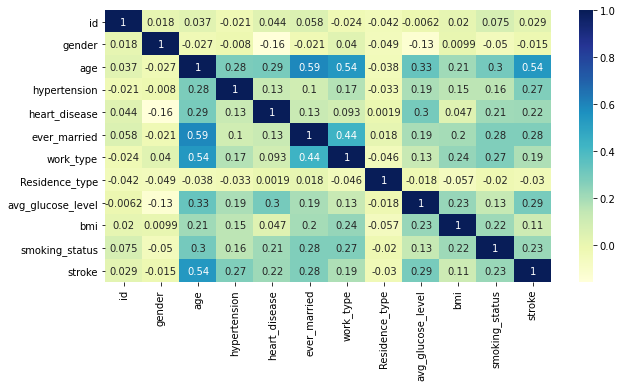

In [10]:
# relation between all the features
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True, cmap="YlGnBu")

In [11]:
# relation between features and dependent variable (stroke)
correlation_matrix = df.corr()
correlation_matrix["stroke"]

id                   0.028663
gender              -0.015456
age                  0.539213
hypertension         0.273580
heart_disease        0.216596
ever_married         0.275331
work_type            0.186562
Residence_type      -0.029694
avg_glucose_level    0.293723
bmi                  0.111616
smoking_status       0.226917
stroke               1.000000
Name: stroke, dtype: float64

In [12]:
# dropping features with low correlation
df = df.drop(['id', 'gender', 'Residence_type', 'bmi'], axis = 1)
df.reset_index(drop=True, inplace=True)

# looking into the data after conversion
df.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
0,81.0,0,0,1,4,125.20,1,0
1,49.0,0,0,1,3,87.06,1,0
2,8.0,0,0,0,1,78.05,0,0
3,27.0,0,0,1,3,85.60,0,0
4,14.0,0,0,0,3,118.81,0,0


In [13]:
# list/data for plots below
categorical_var = ['hypertension','heart_disease','ever_married','work_type','smoking_status','stroke']
continuous_var = ['age','avg_glucose_level']

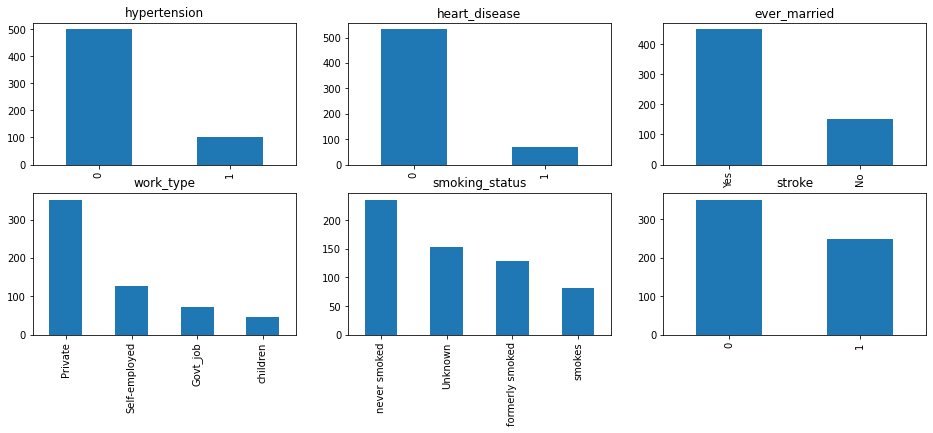

In [14]:
# plotting bar graphs for categorical values

fig = plt.figure(figsize=(16,12))
i = 431

for col in categorical_var:
    plt.subplot(i)
    df_old[col].value_counts().plot(kind='bar')
    plt.title(col)
    i += 1 

plt.show()

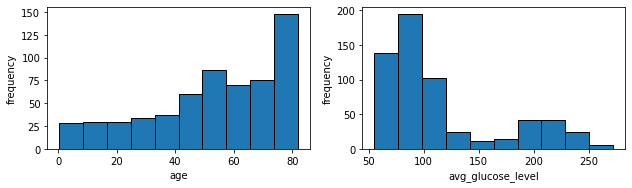

In [15]:
#density plots for continuous data

fig = plt.figure(figsize=(16,12))
i = 431

for col in continuous_var:
    plt.subplot(i)
    plt.hist(df_old[col], edgecolor="black")
    plt.xlabel(f"{col}")
    plt.ylabel("frequency")
    i += 1

plt.show()

### Training the Model

In [16]:
# splitting into featueres and target variable
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'smoking_status']
target = ['stroke']
X = pd.DataFrame(df, columns=features)
Y = pd.DataFrame(df, columns=target)

print(f'Features:\n{X[:5]}')
print(f'Target Variable:\n{Y[:5]}')

Features:
    age  hypertension  ...  avg_glucose_level  smoking_status
0  81.0             0  ...             125.20               1
1  49.0             0  ...              87.06               1
2   8.0             0  ...              78.05               0
3  27.0             0  ...              85.60               0
4  14.0             0  ...             118.81               0

[5 rows x 7 columns]
Target Variable:
   stroke
0       0
1       0
2       0
3       0
4       0


In [17]:
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [18]:
# using XG Boost Classifier to train the model
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 5, random_state=42)
xg_reg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Evaluating Results

#### On Train Set

In [19]:
# running predictions on train set
predictions = xg_reg.predict(X_train)
predictions = predictions.reshape(1,-1)[0]

# a look at first 10 predictions
predictions[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [20]:
# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_train, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_train, predictions)*100}%')

Confusion Matrix:
[[242  28]
 [ 46 118]]
Accuracy Score: 82.94930875576037%


In [21]:
# detailed stats on models performance
print(classification_report(y_train, predictions, target_names = ['No Stroke (Class 0)','Stroke (Class 1)']))

                     precision    recall  f1-score   support

No Stroke (Class 0)       0.84      0.90      0.87       270
   Stroke (Class 1)       0.81      0.72      0.76       164

           accuracy                           0.83       434
          macro avg       0.82      0.81      0.81       434
       weighted avg       0.83      0.83      0.83       434



[[242  28]
 [ 46 118]]


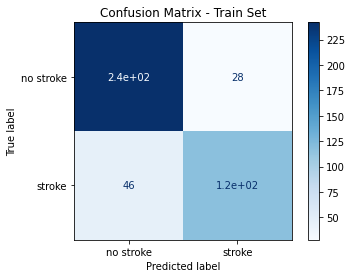

In [22]:
disp = plot_confusion_matrix(xg_reg, X_train, y_train, display_labels=['no stroke', 'stroke'], cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - Train Set")

print(disp.confusion_matrix)

#### On Test Set

In [23]:
# running predictions on test set
predictions = xg_reg.predict(X_test)
predictions = predictions.reshape(1,-1)[0]

# a look at first 10 predictions
predictions[:10]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [24]:
# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_test, predictions)*100}%')

Confusion Matrix:
[[48 16]
 [19 26]]
Accuracy Score: 67.88990825688074%


In [25]:
# detailed stats on models performance
print(classification_report(y_test, predictions, target_names = ['No Stroke (Class 0)','Stroke (Class 1)']))

                     precision    recall  f1-score   support

No Stroke (Class 0)       0.72      0.75      0.73        64
   Stroke (Class 1)       0.62      0.58      0.60        45

           accuracy                           0.68       109
          macro avg       0.67      0.66      0.67       109
       weighted avg       0.68      0.68      0.68       109



[[48 16]
 [19 26]]


<Figure size 360x360 with 0 Axes>

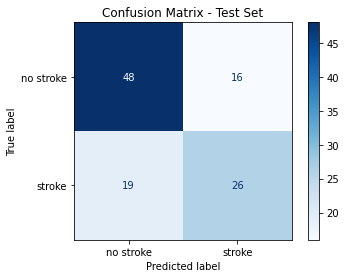

In [26]:
# from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(figsize=(5,5))
disp = plot_confusion_matrix(xg_reg, X_test, y_test, display_labels=['no stroke', 'stroke'], cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - Test Set")

print(disp.confusion_matrix)

### Saving the model

In [27]:
pickle.dump(xg_reg, open("heart_stroke.sav", "wb"))